# human lci analysis
* model makes prediction about what sequences will lead to good vs bad LCI
* here we check model prediction on sequences seen by human participants

In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from csw2022 import *

### reading from database: once stable move outside

'40 blocked': '1000clq',
'interleaved': 'i1000cl', 2018_.../exp_1020103153

In [3]:
def load_dfs(condition):
  ## load psiturk `experiment dataframe`
  sql_df = get_sql_df(get_dataset_code(condition))
  ## from `experiment dataframe`, pull data pertaining to subjects responses
  subj_df = make_subj_df(sql_df['datastring'].iloc[0])
  ## reindex dataframe to make easy to read
  group_df = make_group_df(sql_df)
  # breakup dataframe by story and question nodes
  _,_,(_,group_qdf),(_,group_sdf) = group_df.groupby('type')
  # breakup question dataframe by filler and transition nodes
  (_,group_fqdf),(_,group_tqdf) = group_qdf.groupby('qtype')
  return group_df,group_tqdf,group_sdf,group_qdf,group_fqdf

### dataframe processing

In [4]:
condition='interleaved_rep'
group_df,group_tqdf,group_sdf,group_qdf,group_fqdf = load_dfs(condition)

exp versions found in table:
10.13.18
1000cl
1000clq
9010cl
i1000cl
20B1000cl
RT01B1000cl
csw1000block40.04.07.19
csw1000block01.04.25.19
csw1000block02.04.26.19
csw1000rand50.04.29.19
csw1000block01intheloc.05.01.19
csw1000rand01.05.03.19
csw1000block02.05.07.19
csw1000boldmdp.05.09.19
csw1000insertedblock0.09.22.19
csw1000insertedblock1.09.30.19
csw1000insertedblock1.10.07.19
csw1000insertedblock0.10.08.19
csw1000insertedblock2.10.09.19
csw1000insertedblock2.10.10.19

-loading code version: csw1000block01.04.25.19
N = 56 subjects


In [5]:
## threshold based on filler questions
THRESHOLD = 0.5
plt_group_tqdf = get_thresholded_tqdf(group_tqdf,group_fqdf,threshold=THRESHOLD)
## remove begin node probe (only happens during training)
plt_group_tqdf = select_transition_probes(plt_group_tqdf)

# model analysis

In [8]:
# LOAD model LCI DATA
top_mse_k = 0
adjrand = np.load("model_data/adjustedRand-topmse%i.npy"%top_mse_k)
adjrandD = {'interleaved':adjrand[0],'interleaved_rep':adjrand[1]}
adjrand = adjrandD[condition]

goodLCI2 = adjrand[:,1]>0.99
goodLCI3 = adjrand[:,2]>0.99
goodLCI = np.logical_and(goodLCI2,goodLCI3)

subj_LCIgroup = -np.ones(len(goodLCI),dtype=int)

subj_LCIgroup[
  np.logical_and(
    np.logical_not(goodLCI2),
    np.logical_not(goodLCI3),
  )
] = 0
subj_LCIgroup[
  np.logical_and(
    goodLCI3,
    np.logical_not(goodLCI2),
  )
] = 1
subj_LCIgroup[np.logical_and(goodLCI2,goodLCI3)] = 2

In [9]:
sum(np.logical_not(goodLCI3)),sum(goodLCI3),sum(goodLCI2),sum(goodLCI)

(19, 36, 12, 12)

In [10]:
def add_LCIgroup(_plt_group_tqdf,_subj_LCIgroup):
  L = []
  for idx,subjdf in _plt_group_tqdf.groupby(['subjnum']):
    if idx >= len(_subj_LCIgroup): continue
    subjdf.loc[:,'LCIgroup'] = _subj_LCIgroup[idx]
    L.append(subjdf)
  return pd.concat(L)

plt_group_tqdf = add_LCIgroup(plt_group_tqdf,subj_LCIgroup)
plt_group_tqdf

type   qtype state fromnode true_tonode  \
subjnum block story depth                                                     
0       0     0     1     11    question  transQ   NaN   NODE11      NODE22   
                    2     15    question  transQ   NaN   NODE22      NODE31   
              1     1     30    question  transQ   NaN   NODE11      NODE21   
              2     1     49    question  transQ   NaN   NODE12      NODE21   
              3     1     68    question  transQ   NaN   NODE12      NODE22   
...                                  ...     ...   ...      ...         ...   
54      4     196   1     3583  question  transQ   NaN   NODE11      NODE22   
              197   1     3600  question  transQ   NaN   NODE12      NODE21   
              198   2     3621  question  transQ   NaN   NODE22      NODE32   
              199   1     3634  question  transQ   NaN   NODE11      NODE22   
                    2     3638  question  transQ   NaN   NODE22      NODE31   

                               false_tonode  rfc  \
subjnum block story depth                          
0       0     0     1     11         NODE21  NaN   
                    2     15         NODE32  NaN   
              1     1     30         NODE22  NaN   
              2     1     49         NODE22  NaN   
              3     1     68         NODE21  NaN   
...                                     ...  ...   
54      4     196   1     3583       NODE21  NaN   
              197   1     3600       NODE22  NaN   
              198   2     3621       NODE31  NaN   
              199   1     3634       NODE21  NaN   
                    2     3638       NODE32  NaN   

                                                       true_rfc  \
subjnum block story depth                                         
0       0     0     1     11      subject-Terry_location-jungle   
                    2     15      subject-Terry_location-jungle   
              1     1     30        subject-Larry_location-deep   
              2     1     49      subject-Helen_location-jungle   
              3     1     68       subject-Samuel_location-deep   
...                                                         ...   
54      4     196   1     3583     subject-Lisa_location-jungle   
              197   1     3600   subject-Rachel_location-jungle   
              198   2     3621  subject-Alexander_location-deep   
              199   1     3634    subject-Billy_location-jungle   
                    2     3638    subject-Billy_location-jungle   

                                                      false_rfc  \
subjnum block story depth                                         
0       0     0     1     11      subject-Terry_location-jungle   
                    2     15      subject-Terry_location-jungle   
              1     1     30        subject-Larry_location-deep   
              2     1     49      subject-Helen_location-jungle   
              3     1     68       subject-Samuel_location-deep   
...                                                         ...   
54      4     196   1     3583     subject-Lisa_location-jungle   
              197   1     3600   subject-Rachel_location-jungle   
              198   2     3621  subject-Alexander_location-deep   
              199   1     3634    subject-Billy_location-jungle   
                    2     3638    subject-Billy_location-jungle   

                                response_right  true_on_right  \
subjnum block story depth                                       
0       0     0     1     11             False           True   
                    2     15              True           True   
              1     1     30             False          False   
              2     1     49             False           True   
              3     1     68              True          False   
...                                        ...            ...   
54      4     196   1     3583            True           True   
  

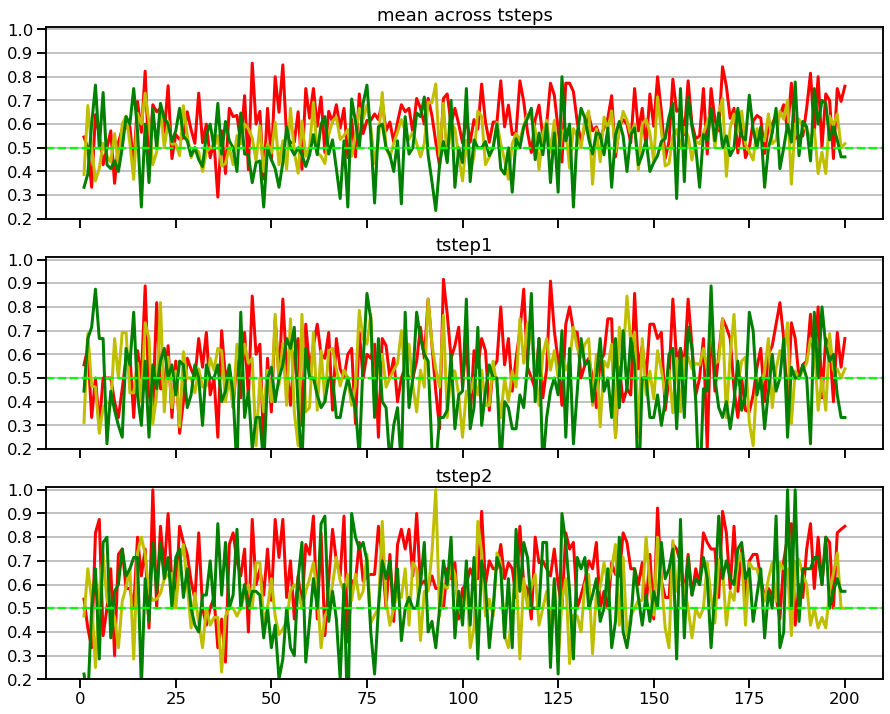

In [11]:

fg,axar = plt.subplots(3,1,figsize=(15,12),sharex=True)

cL = ['r','y','g']
for lci_idx in [0,1,2]:
  ax = axar[0]
  ax.set_title('mean across tsteps')
  LCIgroupM = plt_group_tqdf[plt_group_tqdf.LCIgroup == lci_idx].groupby(['story']).correct_response.mean()
  ax.plot(np.arange(len(LCIgroupM))+1,LCIgroupM,c=cL[lci_idx],lw=3)
  

  LCIgroupM_bytstep = plt_group_tqdf[plt_group_tqdf.LCIgroup == lci_idx].groupby(['story','depth']).correct_response.mean()
  for tstep,tstep_df in LCIgroupM_bytstep.groupby(['depth']):
    ax=axar[tstep]
    ax.set_title("tstep%i"%tstep)
    ax.plot(np.arange(len(tstep_df))+1,tstep_df,c=cL[lci_idx],lw=3)

for ax in axar:
  ax.axhline(0.5,c='lime',ls='--')
  ax.set_yticks(np.arange(0,1.1,.1))
  ax.set_ylim(0.2,1.01)
  ax.grid(axis='y')

plt.savefig('figures/2022/LCI/group-%s-topmse%i.png'%(condition,top_mse_k))

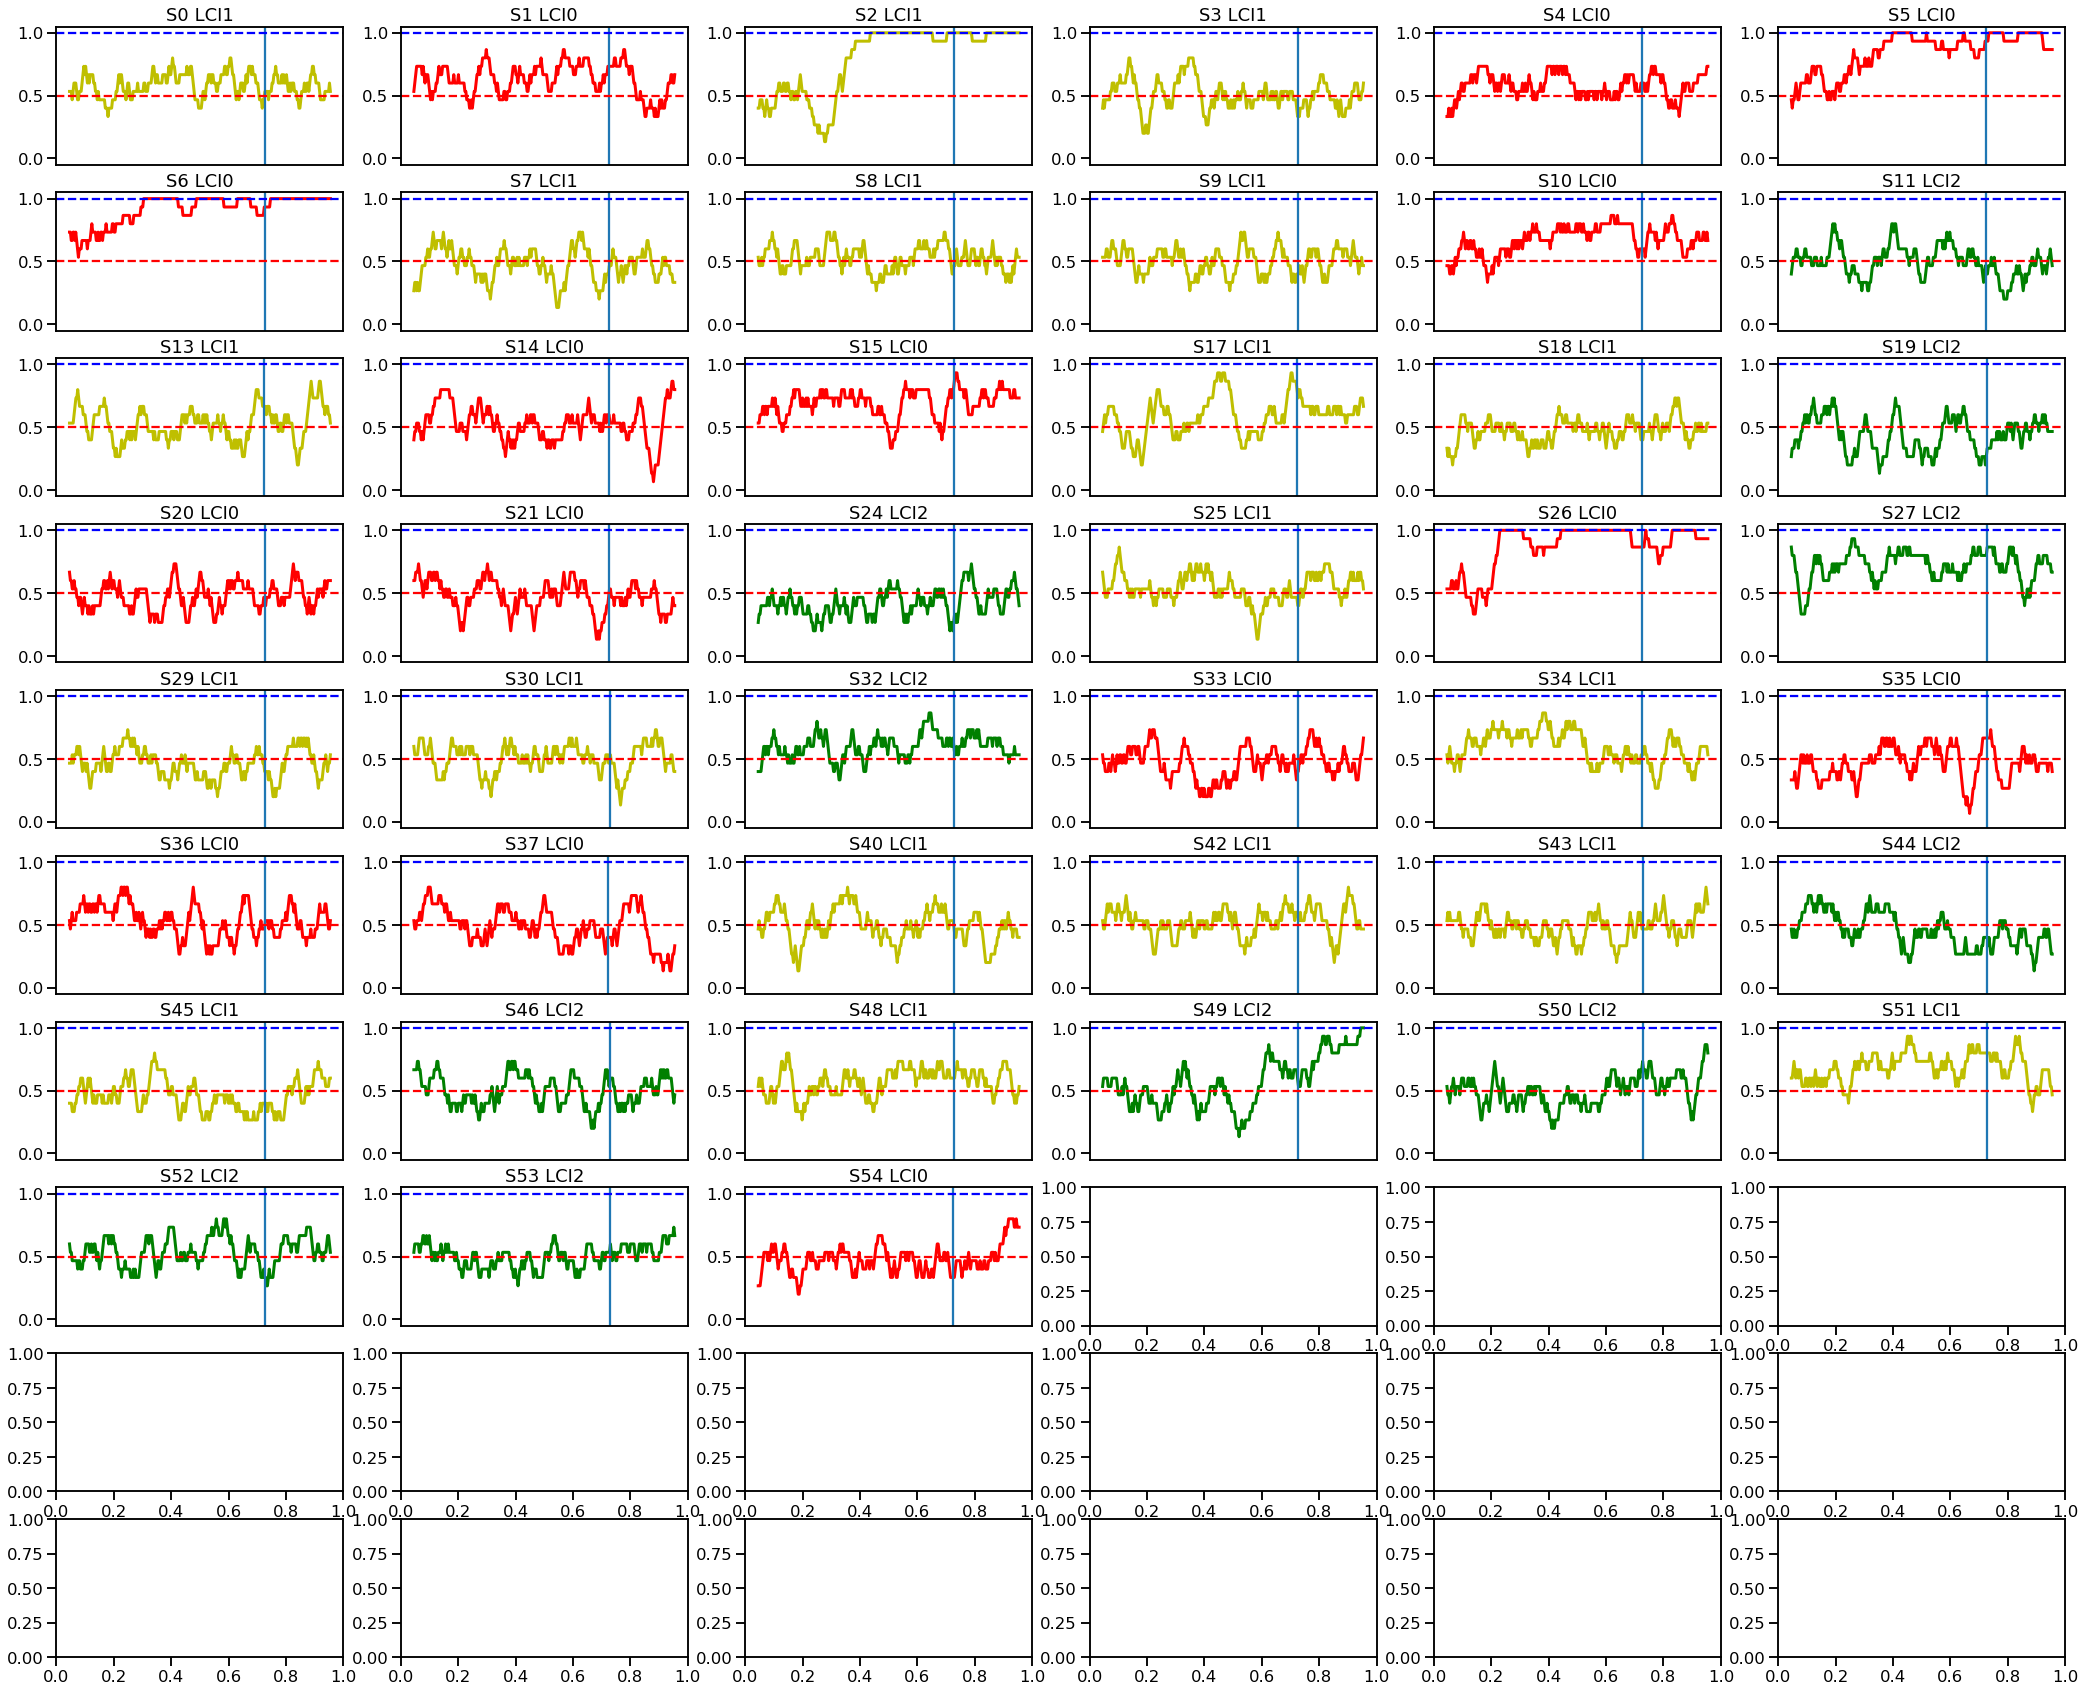

In [12]:
ma_window = 15
subj_data = plt_group_tqdf.correct_response.groupby(['subjnum'])
subj_data_plt = subj_data.apply(mov_avg,ma_window)

fig,axarr = plt.subplots(10,6,figsize=(36,30));axarr=axarr.reshape(-1)
for plt_idx,sub_idx in enumerate(subj_data_plt.index):
  ax = axarr[plt_idx]
  ax.set_title("S%i LCI%i"%(sub_idx,subj_LCIgroup[sub_idx]))
  sub_ma = subj_data_plt[sub_idx]
  ax.plot(range(len(sub_ma)),sub_ma,c=['r','y','g'][subj_LCIgroup[sub_idx]],lw=3)
  ax.axvline(int(len(sub_ma)*(4/5))-15)
  ax.set_xticks([])
  ax.set_ylim(-0.05,1.05)
  ax.axhline(0.5,c='r',ls='--')
  ax.axhline(1,c='b',ls='--')

title = 'subs_%s'%(condition)
plt.savefig('figures/2022/LCI/sub-%s-topmse%i.png'%(condition,top_mse_k))